In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
#MNIST images. -> pytorch tensors
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root = '../Data',train = True,download=True,transform = transform)

In [4]:
test_data = datasets.MNIST(root = '../Data',train = False,download=True,transform = transform)

In [5]:
type(train_data)

torchvision.datasets.mnist.MNIST

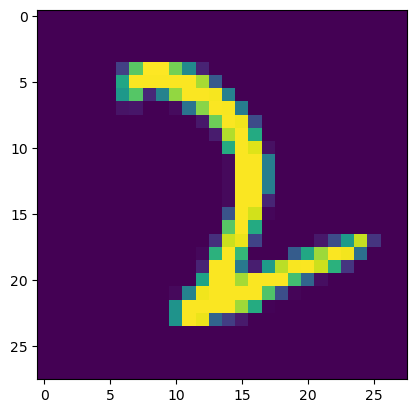

In [29]:
import random
num = random.randint(0,60000)
plt.imshow(train_data[num][0].reshape(28,28))

In [7]:
img,label = train_data[num-1]

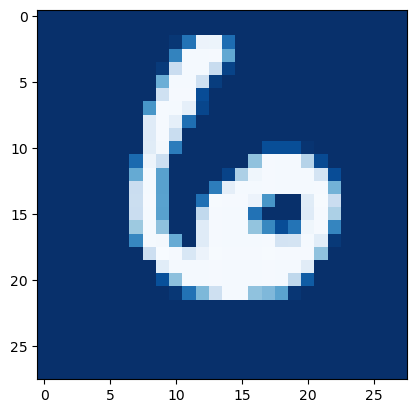

In [30]:
plt.imshow(img.reshape(28,28),cmap='Blues_r')

In [9]:
torch.manual_seed(101)
device = torch.device("mps")
train_batch_size = 100
test_batch_size = 500
train_loader = DataLoader(train_data,batch_size=train_batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_batch_size,shuffle=False)

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


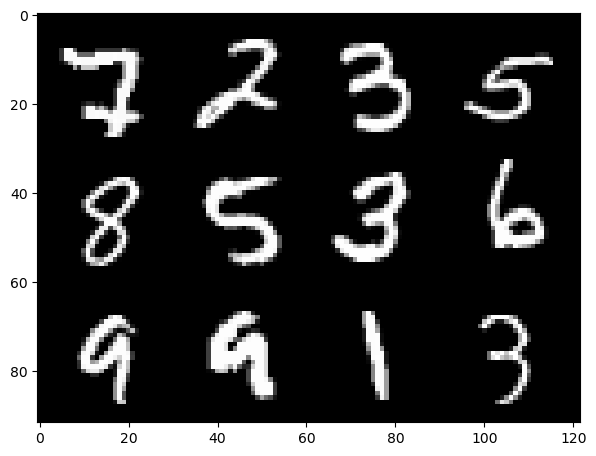

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int= lambda x: f'{x:4}'))
for images,labels in train_loader:
    break
print('Labels: ',labels[:12].numpy())
im = make_grid(images[:12],nrow=4)
plt.figure(figsize=(7,7))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### Model

In [11]:
class Model(nn.Module):
    
    def __init__(self,in_size=784,out_size=10,layers = [128,64,32]):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(in_size,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],layers[2])
        self.out = nn.Linear(layers[2],out_size)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [12]:
torch.manual_seed(101)
model = Model(layers=[128,64,32]).to(device)
model

Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
total = 0
for p in model.parameters():
    total += p.numel()
    print(p.numel())
print("Total :", total)

100352
128
8192
64
2048
32
320
10
Total : 111146


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [15]:
#change shape - >[100,784]
images.shape

torch.Size([100, 1, 28, 28])

In [16]:
images.view(100,-1).shape

torch.Size([100, 784])

### Training

In [17]:
import time
start_time = time.time()

num_epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct= []

for epoch in range(num_epochs):
    trn_crt = 0
    tst_crt = 0
    for b,(X_train,y_train) in enumerate(train_loader):
        X_train,y_train = X_train.to(device),y_train.to(device)
        b += 1
        y_pred = model.forward(X_train.view(100,-1))
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred.data,1)[1]
        batch_correct = (predicted == y_train).sum()
        trn_crt += batch_correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_crt*100/(100*b)
            print(f'epoch : {epoch+1} batch : {b} loss : {loss.item()} accuracy : {acc}')
            
    train_losses.append(loss)
    train_correct.append(trn_crt)
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            X_test,y_test = X_test.to(device),y_test.to(device)
            y_val = model.forward(X_test.view(test_batch_size,-1))
            predicted = torch.max(y_val.data,1)[1]
            tst_crt += (predicted == y_test).sum()
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_crt)






end_time = time.time()
print(f"{(end_time-start_time)/60} mins")

epoch : 1 batch : 200 loss : 0.25158295035362244 accuracy : 72.70999908447266
epoch : 1 batch : 400 loss : 0.25278303027153015 accuracy : 81.98999786376953
epoch : 1 batch : 600 loss : 0.2256438136100769 accuracy : 85.711669921875
epoch : 2 batch : 200 loss : 0.15956445038318634 accuracy : 94.74500274658203
epoch : 2 batch : 400 loss : 0.27624186873435974 accuracy : 94.84249877929688
epoch : 2 batch : 600 loss : 0.07268206775188446 accuracy : 95.00333404541016
epoch : 3 batch : 200 loss : 0.14092910289764404 accuracy : 96.2750015258789
epoch : 3 batch : 400 loss : 0.10439389199018478 accuracy : 96.31500244140625
epoch : 3 batch : 600 loss : 0.19838783144950867 accuracy : 96.40166473388672
epoch : 4 batch : 200 loss : 0.06634429842233658 accuracy : 97.0199966430664
epoch : 4 batch : 400 loss : 0.1089974045753479 accuracy : 97.08499908447266
epoch : 4 batch : 600 loss : 0.0609329491853714 accuracy : 97.12166595458984
epoch : 5 batch : 200 loss : 0.08312756568193436 accuracy : 97.69499969

In [18]:
for epoch in range(10):
    crt = 0
    len_y =0
    for X_train,y_train in train_loader:
        X_train,y_train = X_train.to(device),y_train.to(device)
        y_pred = model.forward(X_train.view(train_batch_size,-1))
        pred = torch.max(y_pred.data,1)[1]
        crt += (pred == y_train).sum()
        len_y += len(y_train)
        loss = criterion(y_pred,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    acc = crt*100/len_y
    print(f"epoch : {epoch+1} loss : {loss.item()} acc : {acc}")
    

epoch : 1 loss : 0.041685234755277634 acc : 99.14167022705078
epoch : 2 loss : 0.051912859082221985 acc : 99.30999755859375
epoch : 3 loss : 0.003432227997109294 acc : 99.25
epoch : 4 loss : 0.024378623813390732 acc : 99.4566650390625
epoch : 5 loss : 0.01593209058046341 acc : 99.41500091552734
epoch : 6 loss : 0.055408574640750885 acc : 99.50833129882812
epoch : 7 loss : 0.01979684643447399 acc : 99.57166290283203
epoch : 8 loss : 0.0009641540236771107 acc : 99.53333282470703
epoch : 9 loss : 0.05761608108878136 acc : 99.64666748046875
epoch : 10 loss : 0.06660082191228867 acc : 99.60333251953125


In [38]:
img = train_data[0][0].reshape(28,28).numpy()

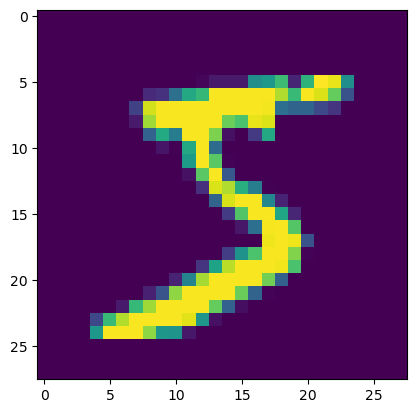

In [48]:
plt.imshow(img,aspect=1)

In [49]:
import numpy as np

gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

In [50]:
from scipy.signal import convolve2d

# Assuming 'image_matrix' is your 28x28 image as a NumPy array
blurred_image = convolve2d(img, gaussian_kernel, mode='same', boundary='fill')

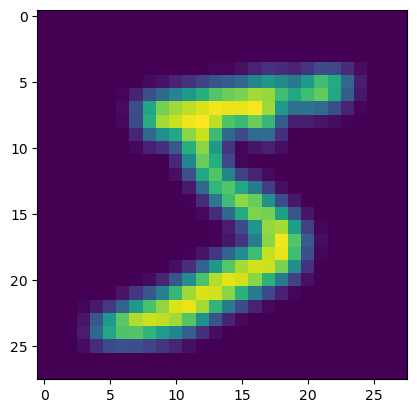

In [51]:
plt.imshow(blurred_image)

In [53]:
from PIL import Image
import numpy as np

# Load the image
image_path = '/Users/aadityajoshi/Downloads/archive-12/Dog and Cat .png/Dog/d10.png'
image = Image.open(image_path)

# Convert the image to grayscale (optional, if you need a single channel)
# image = image.convert('L')

# Convert the image to a NumPy array
image_matrix = np.array(image)

# Print the shape and type of the image matrix
print(image_matrix.shape)

(436, 458, 3)


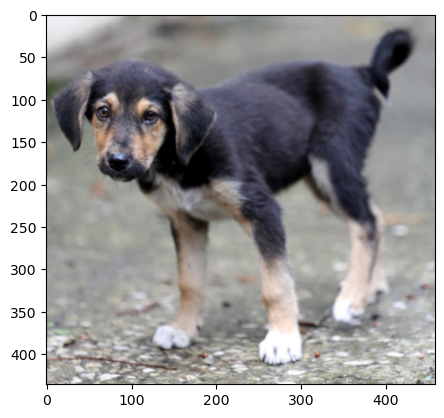

In [54]:
plt.imshow(image_matrix)

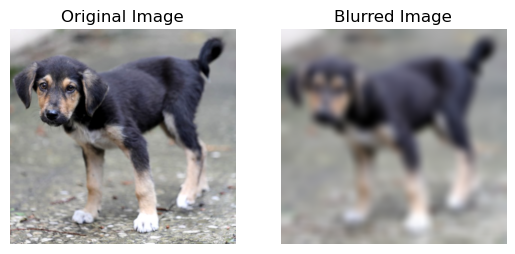

In [61]:
import cv2
import numpy as np

# Load the image
image_path = '/Users/aadityajoshi/Downloads/archive-12/Dog and Cat .png/Dog/d10.png'
image = cv2.imread(image_path)

# Define the Gaussian kernel size and sigma
kernel_size = (27, 27)  # Kernel size (should be odd and positive, e.g., 3, 5, 7, etc.)
sigma = 9  # Standard deviation for Gaussian kernel

# Apply Gaussian blur to the image
blurred_image = cv2.(image, kernel_size, sigma)

# Display the original and blurred images (optional)
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Blurred Image')
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')

plt.show()

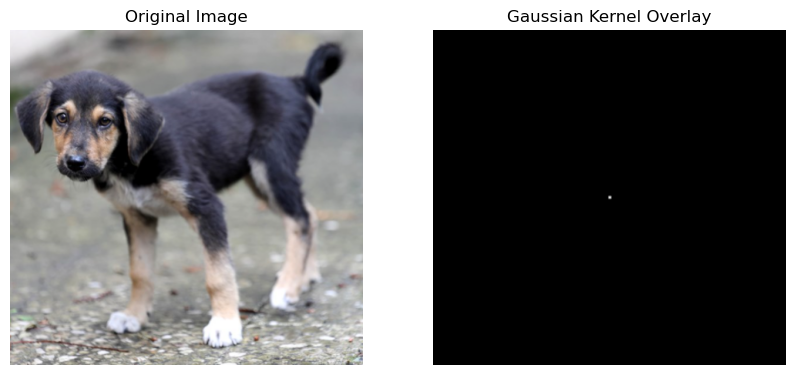

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/Users/aadityajoshi/Downloads/archive-12/Dog and Cat .png/Dog/d10.png'
image = cv2.imread(image_path)

# Convert the image to grayscale for better visualization (optional)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define the kernel size and sigma
kernel_size = 5  # Adjust as needed (3, 5, 7, etc.)
sigma = 1.5  # Standard deviation

# Create a Gaussian kernel
gaussian_kernel = cv2.getGaussianKernel(ksize=kernel_size, sigma=sigma)
gaussian_kernel_2d = np.outer(gaussian_kernel, gaussian_kernel)

# Create an outline effect using the kernel
# Create an image to visualize the kernel as an overlay
kernel_overlay = np.zeros_like(gray_image)

# Define the center position to overlay the kernel
center_x, center_y = gray_image.shape[1] // 2, gray_image.shape[0] // 2

# Apply the kernel to the overlay image
for i in range(kernel_size):
    for j in range(kernel_size):
        # Calculate the position of the kernel
        x = center_x - kernel_size // 2 + i
        y = center_y - kernel_size // 2 + j
        # Ensure we are within bounds
        if 0 <= x < gray_image.shape[1] and 0 <= y < gray_image.shape[0]:
            kernel_overlay[y, x] = gaussian_kernel_2d[i, j] * 255  # Scale for visualization

# Normalize the overlay for better visibility
kernel_overlay = cv2.normalize(kernel_overlay, None, 0, 255, cv2.NORM_MINMAX)

# Display the original image and the kernel overlay
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Kernel overlay
plt.subplot(1, 2, 2)
plt.title('Gaussian Kernel Overlay')
plt.imshow(kernel_overlay, cmap='gray')
plt.axis('off')

plt.show()

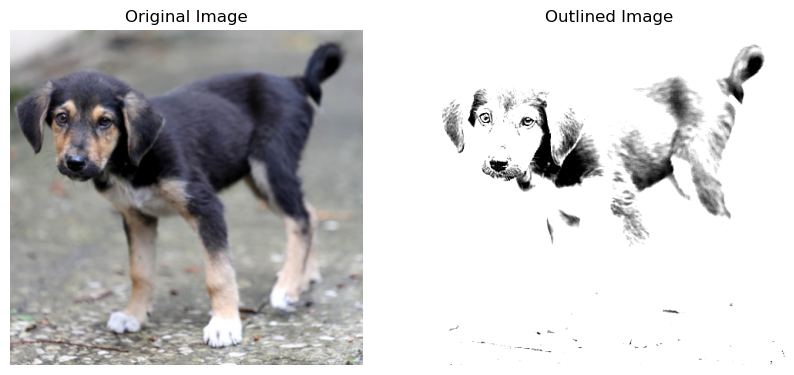

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/Users/aadityajoshi/Downloads/archive-12/Dog and Cat .png/Dog/d10.png'
image = cv2.imread(image_path)

# Convert the image to grayscale for edge detection
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define the Laplacian kernel for outlining
laplacian_kernel = np.array([
    [-1, -1, -1],
    [-1,  12, -1],
    [-1, -1, -1]
])

# Apply the kernel to the image using convolution
outlined_image = cv2.filter2D(gray_image, -1, laplacian_kernel)

# Normalize the outlined image for better visualization
outlined_image = cv2.normalize(outlined_image, None, 0, 255, cv2.NORM_MINMAX)

# Visualize the original and outlined images
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the outlined image
plt.subplot(1, 2, 2)
plt.title('Outlined Image')
plt.imshow(outlined_image, cmap='gray')
plt.axis('off')

plt.show()